In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import squareform

In [3]:
import sys
print(sys.executable)

/Users/sofiascaiano/Documents/maestria/Data Mining EyF/churn/venv/bin/python


In [4]:
df = pd.read_csv("/Users/sofiascaiano/Documents/maestria/Data Mining EyF/datasets/competencia_01_target.csv")
df['foto_mes'] = pd.to_datetime(df['foto_mes'])

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/4054144402.py:1: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/sofiascaiano/Documents/maestria/Data Mining EyF/datasets/competencia_01_target.csv")


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978439 entries, 0 to 978438
Columns: 155 entries, numero_de_cliente to target
dtypes: datetime64[ns](1), float64(89), int64(64), object(1)
memory usage: 1.1+ GB


In [346]:
df.groupby('foto_mes')['target'].value_counts()

foto_mes    target  
2021-01-31  CONTINUA    160087
            BAJA+2         824
            BAJA+1         616
2021-02-28  CONTINUA    160298
            BAJA+2        1027
            BAJA+1         830
2021-03-31  CONTINUA    161125
            BAJA+1        1034
            BAJA+2         950
2021-04-30  CONTINUA    161334
            BAJA+2        1130
            BAJA+1         954
Name: count, dtype: int64

In [237]:
X = df[(df['target'] == 'BAJA+2') & (df['foto_mes'] == '2021-04-30')].dropna(subset=['target']).drop(columns=['numero_de_cliente', 'foto_mes', 'target'])

In [196]:
# features = ['active_quarter', 'cliente_vip', 'mrentabilidad', 'mcomisiones', 'cliente_antiguedad', 'cliente_edad', 'internet', 'mactivos_margen', 'mpasivos_margen', 'cproductos', 'tcuentas', 'ccaja_ahorro', 'ccuenta_corriente', 'mcaja_ahorro', 'mcaja_ahorro_dolares', 'mcuentas_saldo', 'ctarjeta_debito_transacciones', 'ctarjeta_visa', 'ctarjeta_visa_transacciones', 'mtarjeta_visa_consumo', 'ctarjeta_master', 'ctarjeta_master_transacciones', 'mtarjeta_master_consumo', 'cprestamos_personales', 'mprestamos_personales', 'cplazo_fijo', 'cinversion1', 'cinversion2', 'mpayroll', 'ccomisiones_mantenimiento', 'ctransferencias_recibidas', 'ctransferencias_emitidas', 'cextraccion_autoservicio', 'ccallcenter_transacciones', 'ccajas_consultas', 'ccajas_extracciones', 'catm_trx', 'catm_trx_other', 'ctrx_quarter', 'tmobile_app', 'cmobile_app_trx', 'Master_status', 'Visa_status', 'Master_msaldototal', 'Visa_msaldototal', 'Master_mlimitecompra', 'Visa_mlimitecompra']

In [179]:
# features = ['active_quarter', 'cliente_vip', 'mrentabilidad', 'cliente_antiguedad', 'cliente_edad']

In [239]:
# ==========================
# 2. Generar datos sintéticos
# ==========================
X_synthetic = np.copy(X)
for i in range(X.shape[1]):
    np.random.shuffle(X_synthetic[:, i])

X_combined = np.vstack((X, X_synthetic))
y_combined = np.array([1]*len(X) + [0]*len(X_synthetic))

# ==========================
# 3. Entrenar Random Forest
# ==========================
rf = RandomForestClassifier(n_estimators=1500, random_state=131213, n_jobs=-1)
rf.fit(X_combined, y_combined)

# ==========================
# 4. Calcular matriz de proximidad
# ==========================
leaves = rf.apply(X)
n_samples, n_trees = leaves.shape

proximity = np.zeros((n_samples, n_samples))
for t in range(n_trees):
    for i in range(n_samples):
        for j in range(i, n_samples):
            if leaves[i, t] == leaves[j, t]:
                proximity[i, j] += 1
                if i != j:
                    proximity[j, i] += 1
proximity /= n_trees

# ==========================
# 5. Distancia = 1 - proximidad
# ==========================
distance_matrix = 1 - proximity

# Convertir a forma condensada
distance_condensed = squareform(distance_matrix)

/Users/sofiascaiano/Documents/maestria/Data Mining EyF/churn/venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Clusters encontrados: [1 2 3]


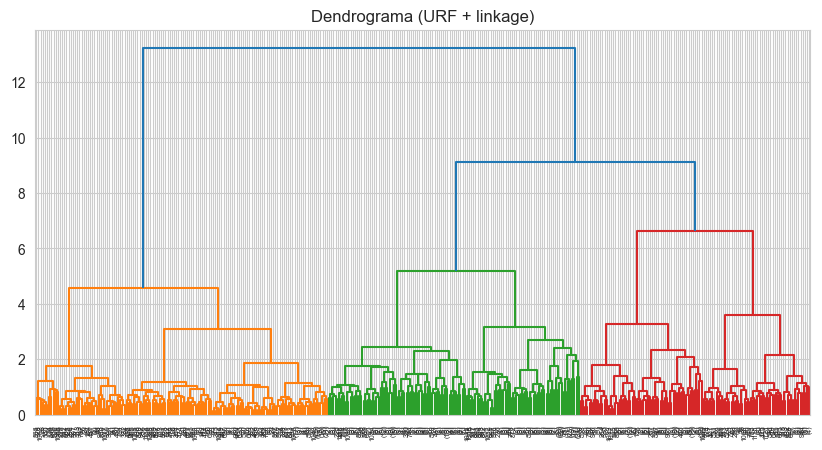

In [242]:
# ==========================
# 6. Clustering jerárquico con linkage()
# ==========================
Z = linkage(distance_condensed, method="ward")  # 'average', 'complete', 'single'

# Cortar el dendrograma 
labels = fcluster(Z, t=3, criterion="maxclust")

print("Clusters encontrados:", np.unique(labels))

# ==========================
# 7. Dendrograma
# ==========================
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode="level", p=8, color_threshold=8)#0.5*max(Z[:,2]))
plt.title("Dendrograma (URF + linkage)")
plt.show()

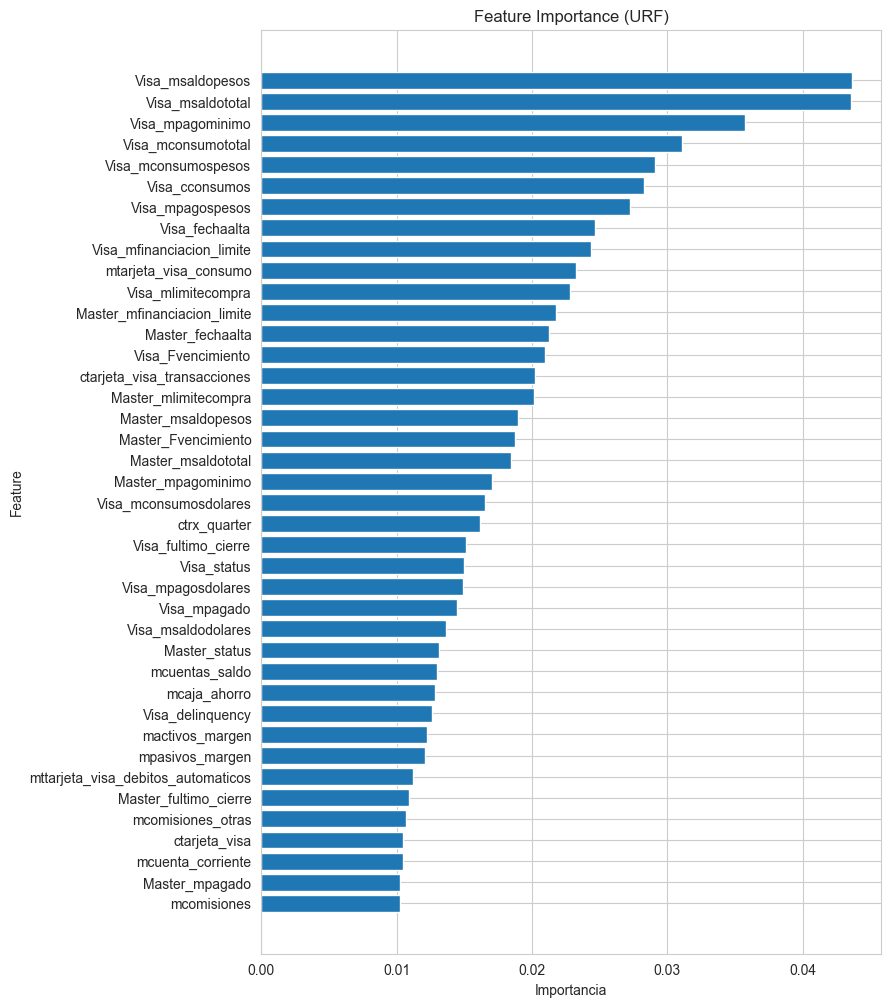

In [243]:
# ==========================
# 4. Importancia de features
# ==========================
importances = rf.feature_importances_
df_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

df_importances = df_importances[df_importances['Importance'] > 0.01]

plt.figure(figsize=(8,12))
plt.barh(df_importances["Feature"], df_importances["Importance"])
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Feature Importance (URF)")
plt.gca().invert_yaxis()
plt.show()

In [244]:
df_baja_202104 = df.iloc[X.index]
df_baja_202104['cluster'] = labels
df_baja_202104['mes_baja'] = df_baja_202104['foto_mes'] + pd.DateOffset(months=2)

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/3491256177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_baja_202104['cluster'] = labels
/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/3491256177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_baja_202104['mes_baja'] = df_baja_202104['foto_mes'] + pd.DateOffset(months=2)


In [245]:
df_baja_202104['cluster'].value_counts()

cluster
2    518
3    313
1    299
Name: count, dtype: int64

In [246]:
df_cluster = pd.merge(df, df_baja_202104[['numero_de_cliente', 'cluster', 'mes_baja']], on='numero_de_cliente', how='inner')
df_cluster['meses_hasta_baja'] = (df_cluster['mes_baja'].dt.year - df_cluster['foto_mes'].dt.year) * 12 + (
            df_cluster['mes_baja'].dt.month - df_cluster['foto_mes'].dt.month)

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


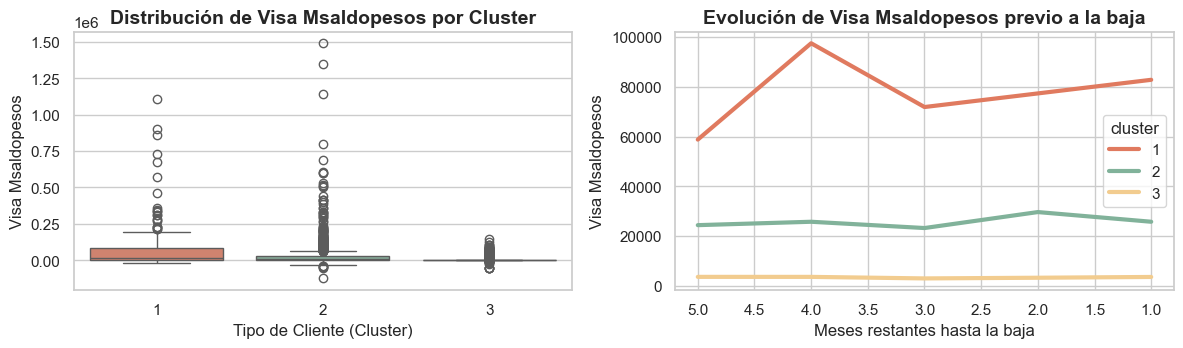

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


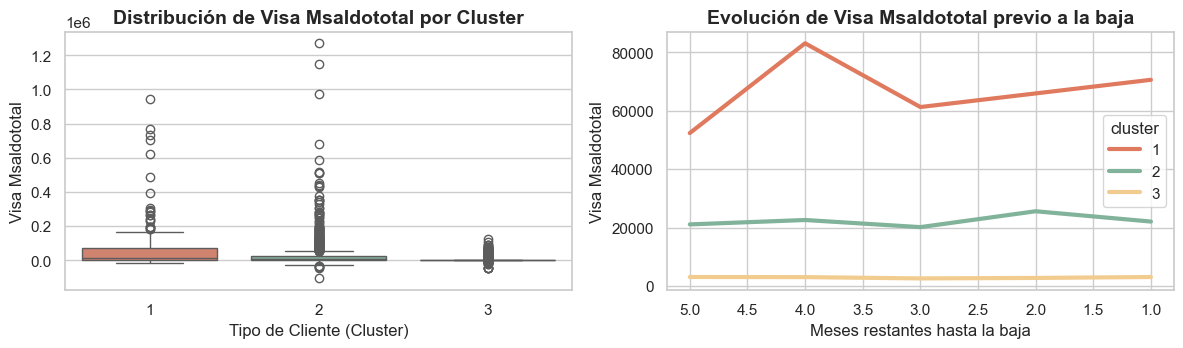

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


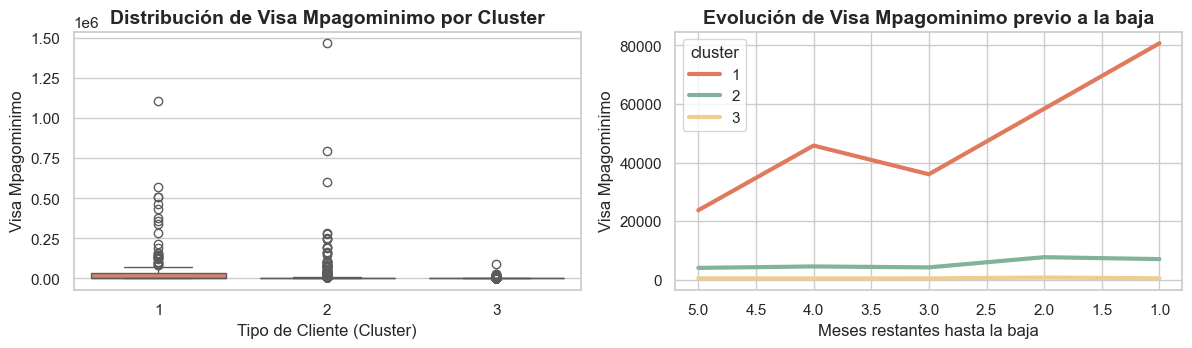

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


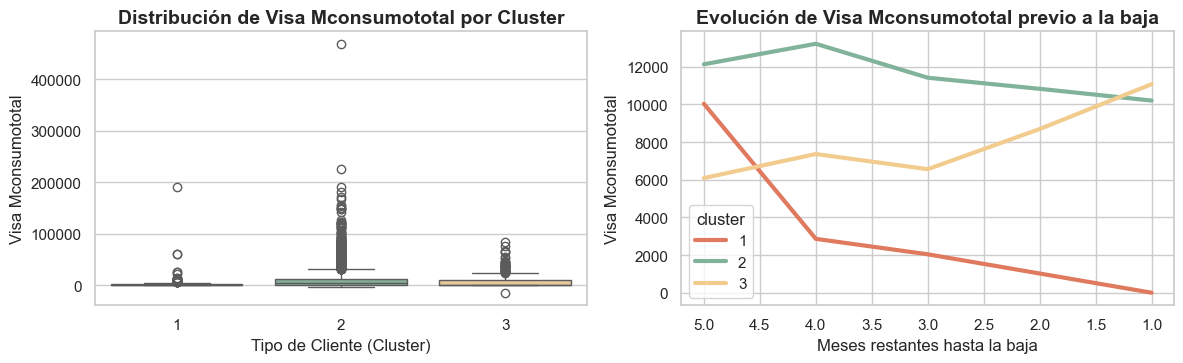

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


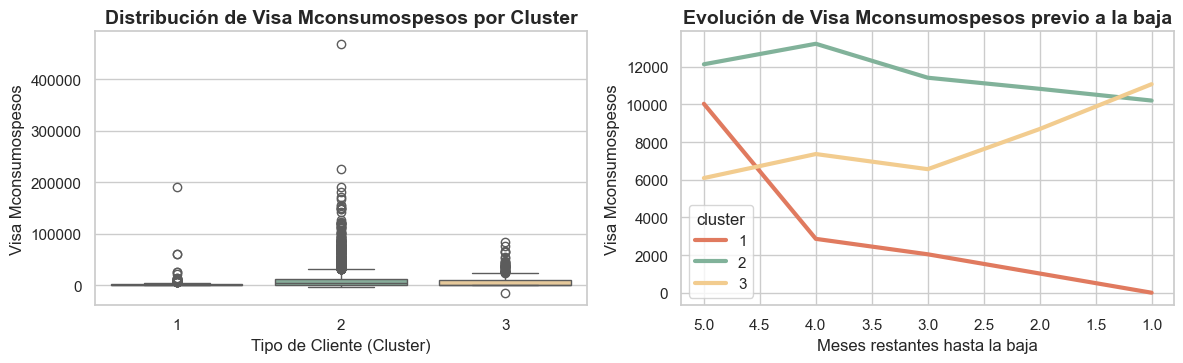

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


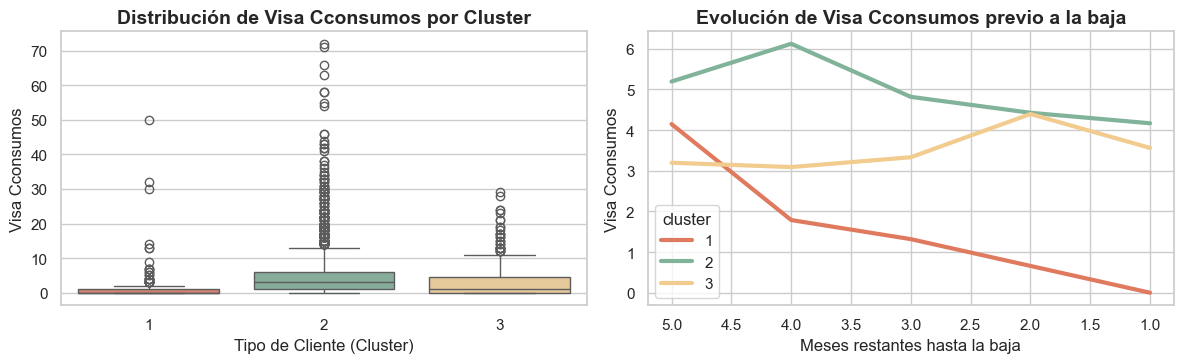

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


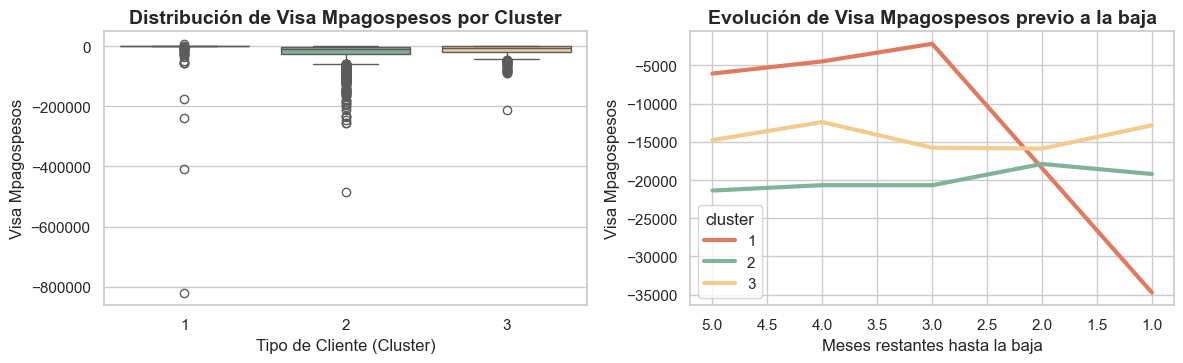

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


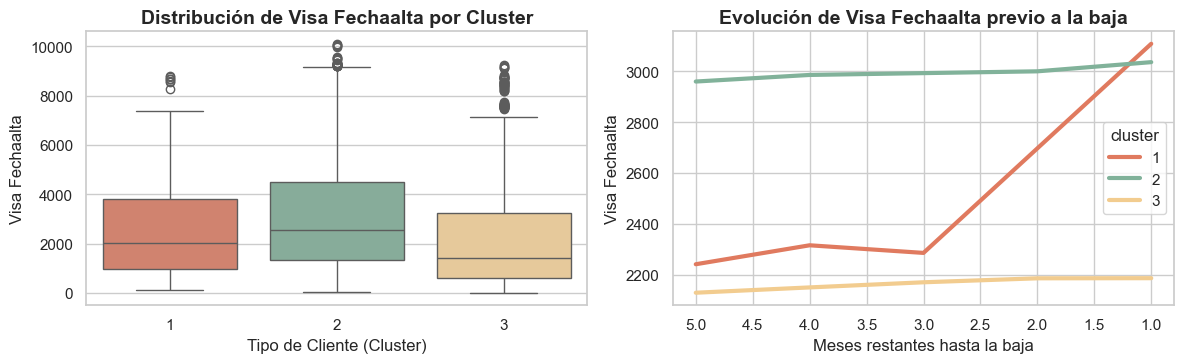

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


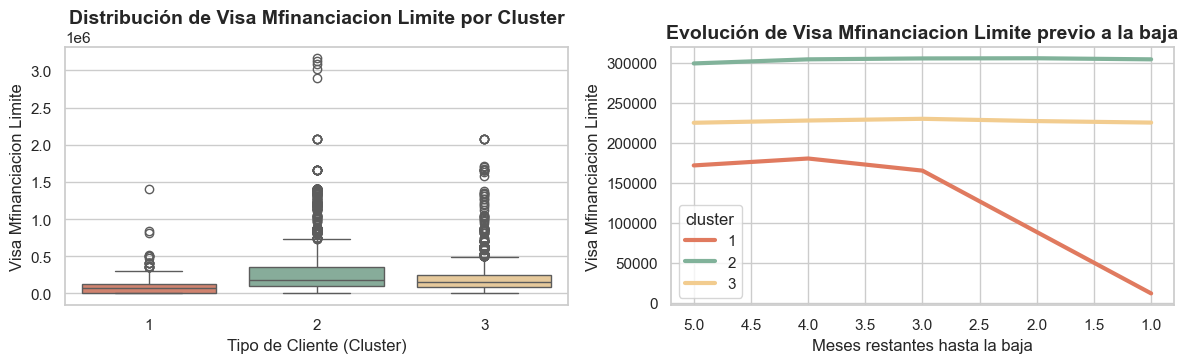

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


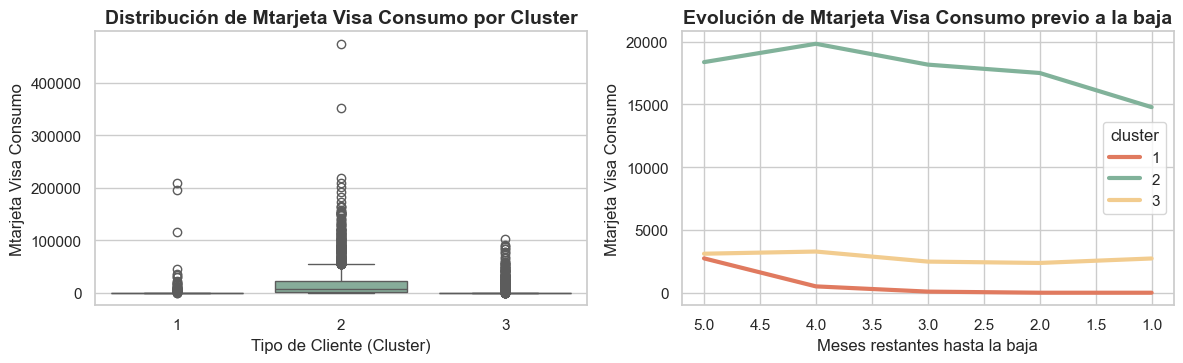

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


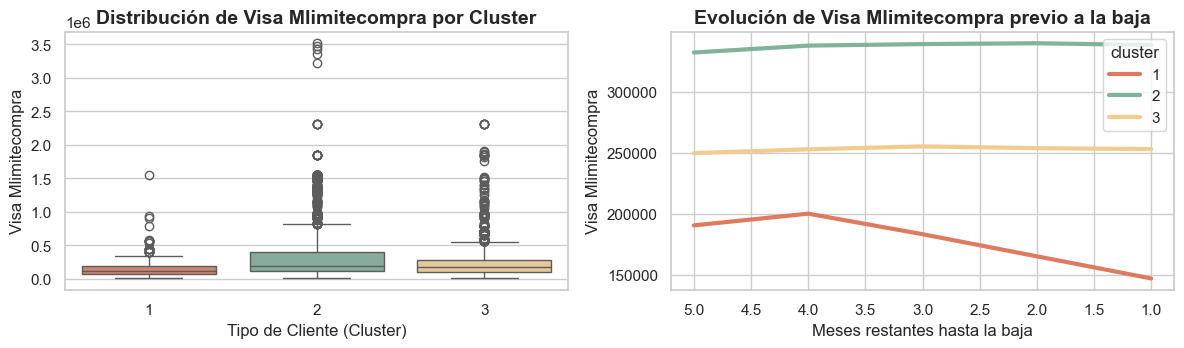

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


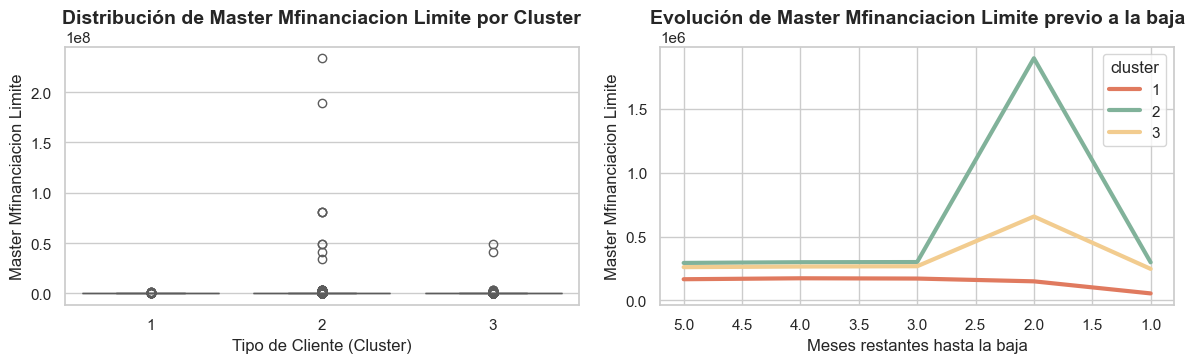

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


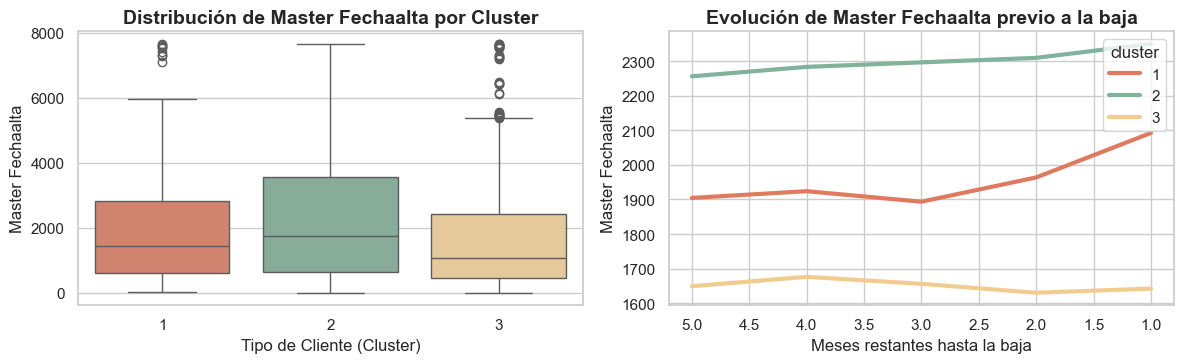

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


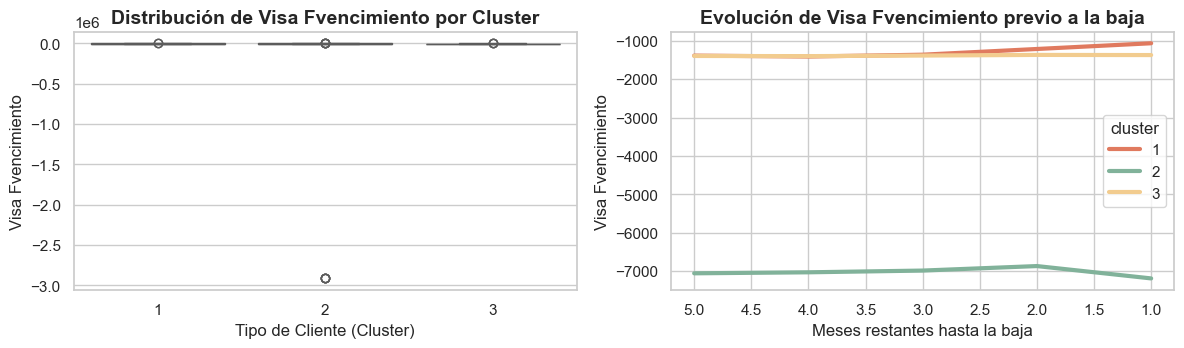

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


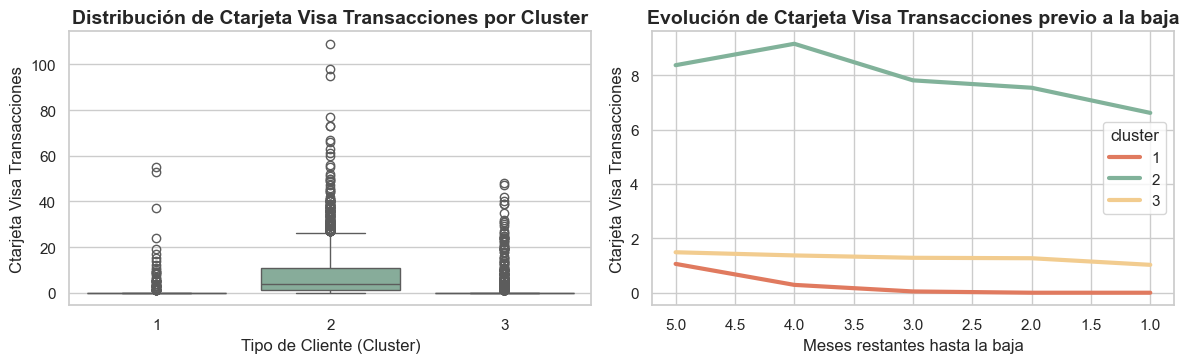

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


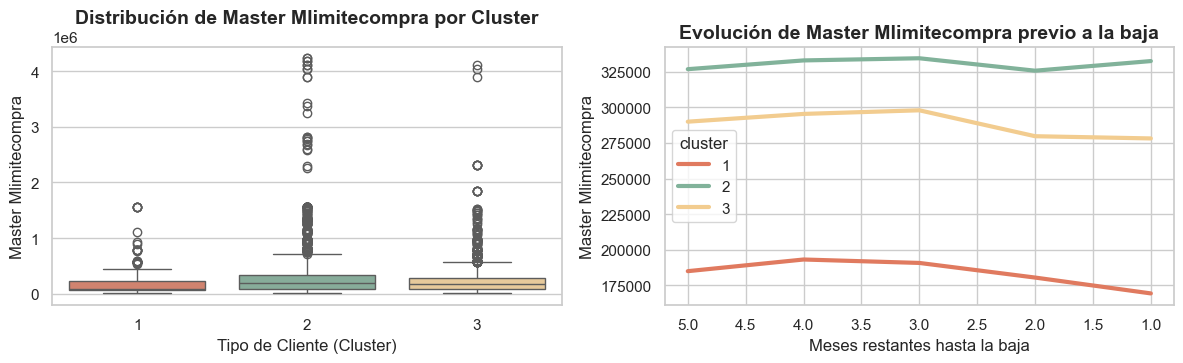

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


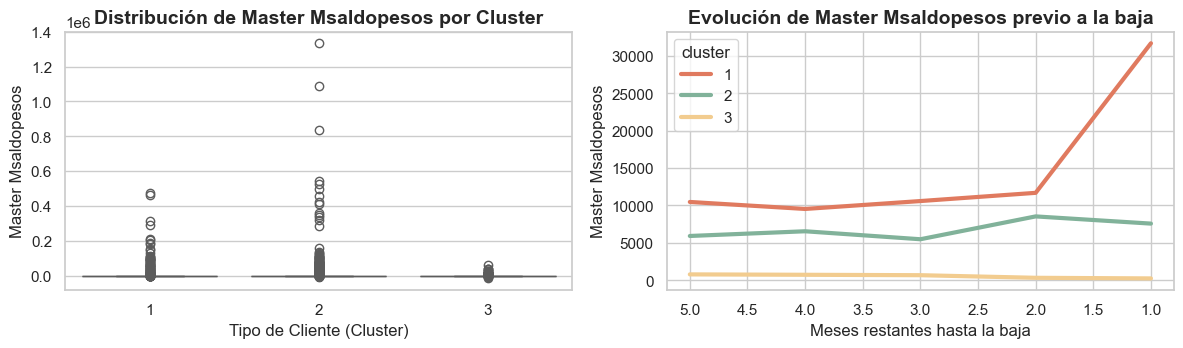

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


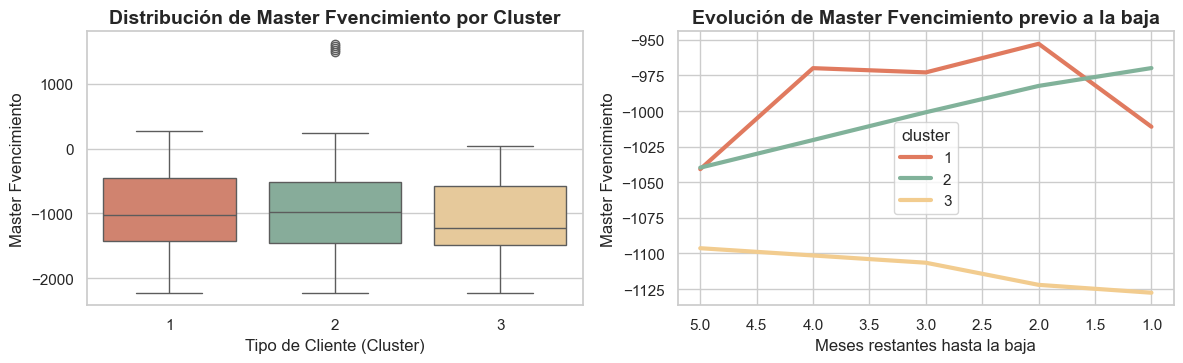

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


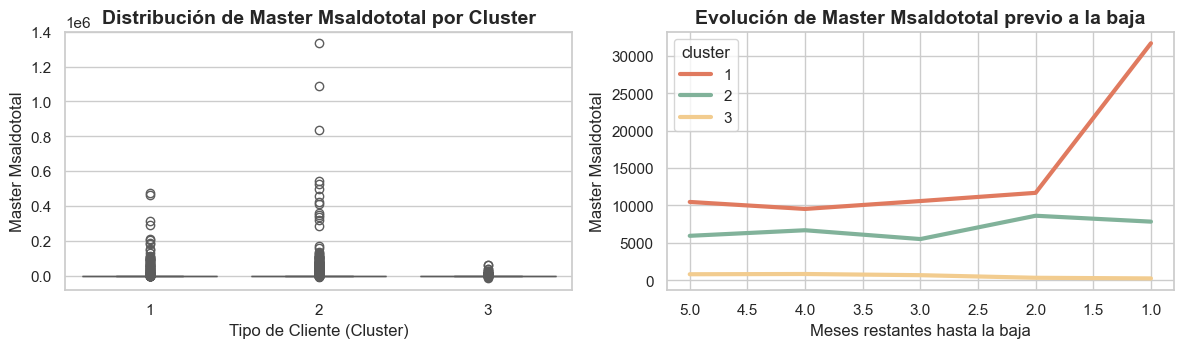

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


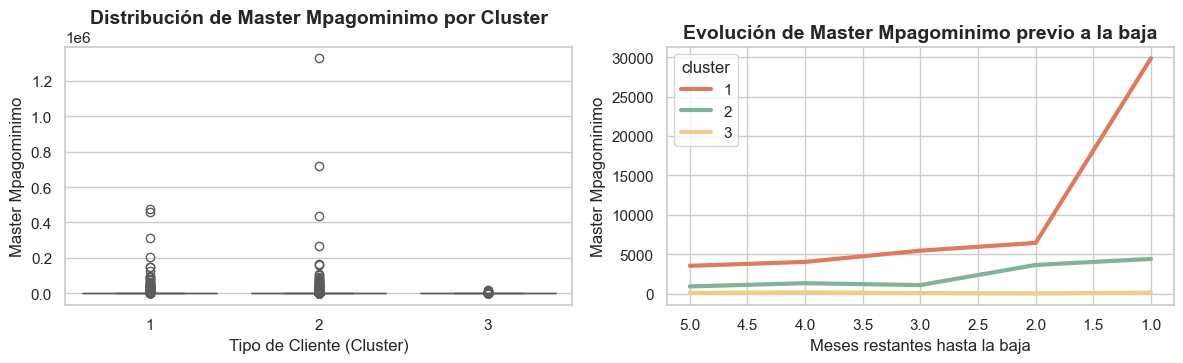

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


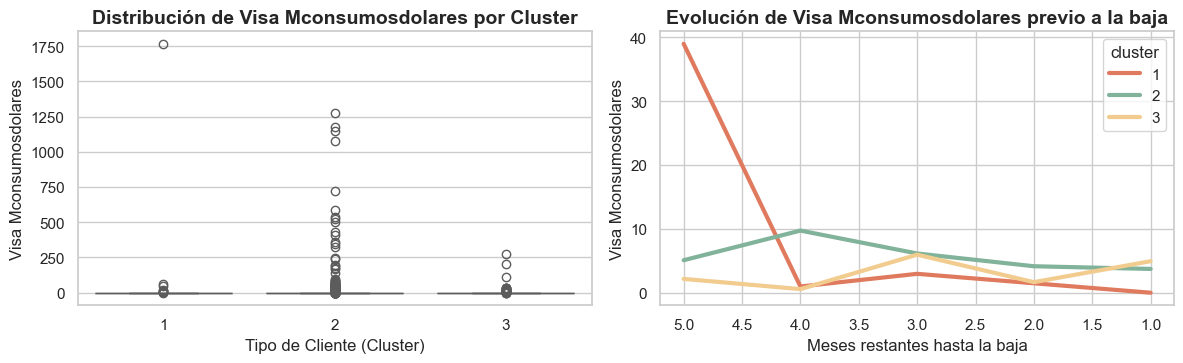

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


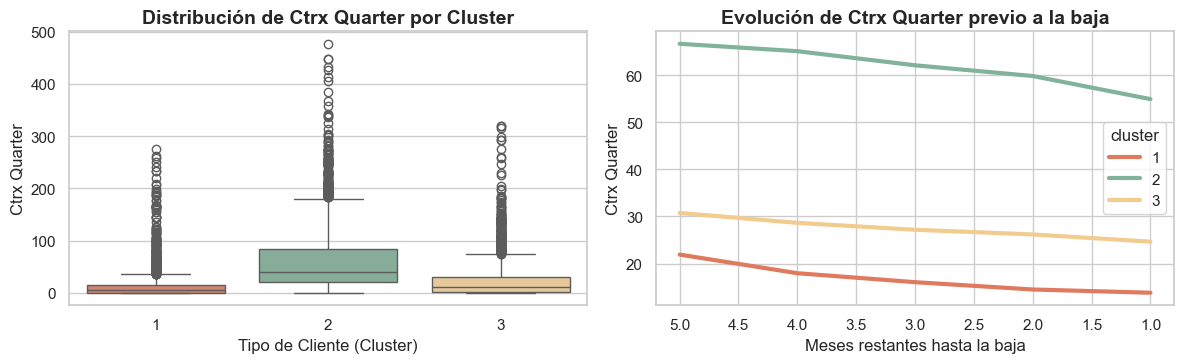

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


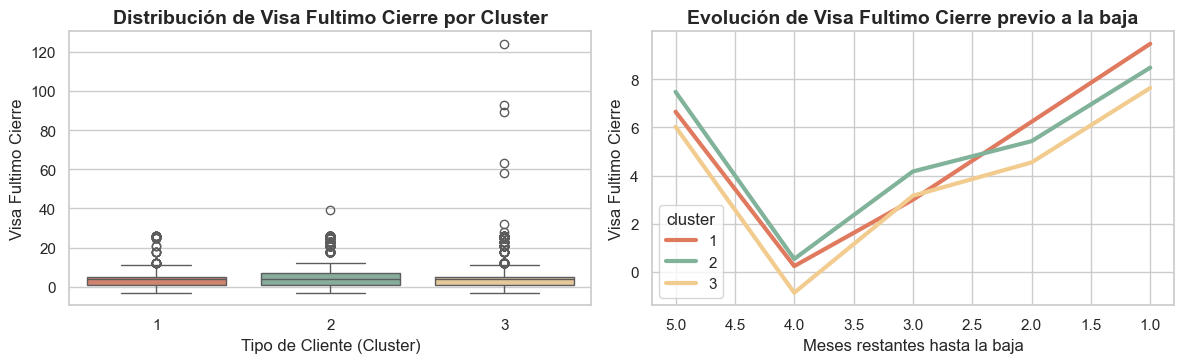

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


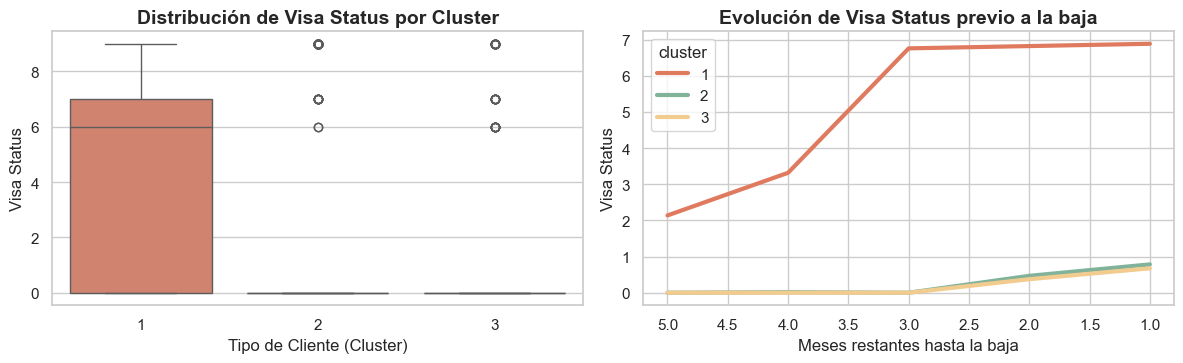

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


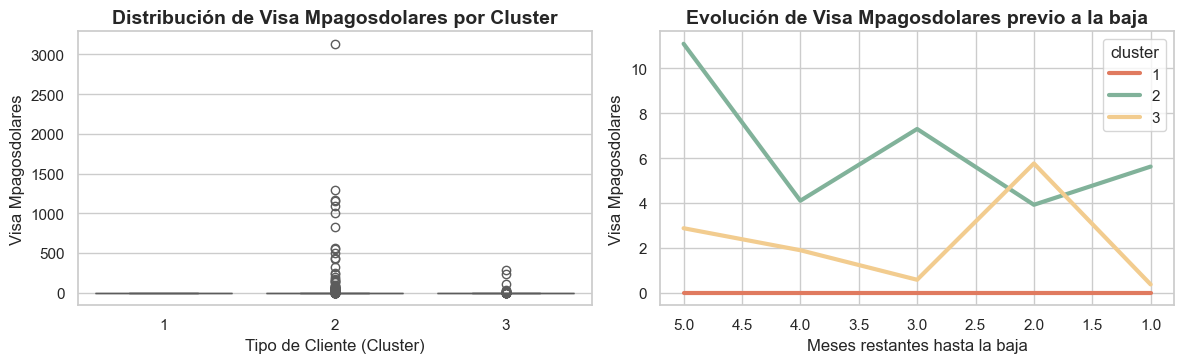

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


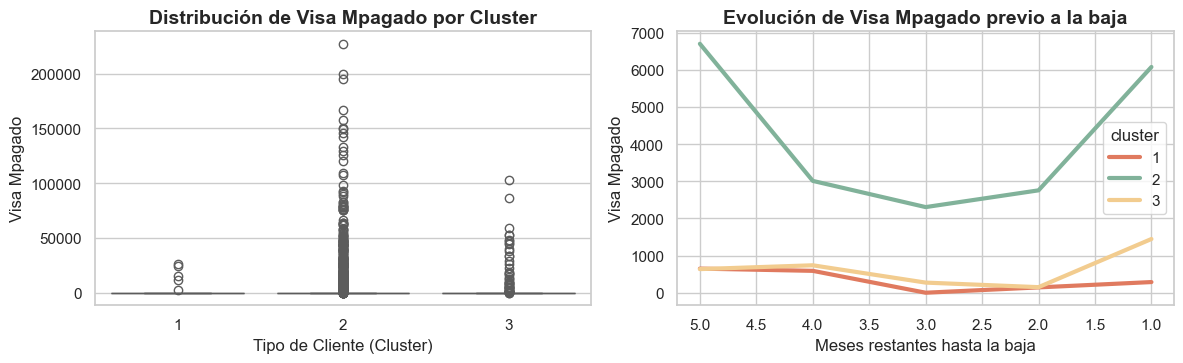

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


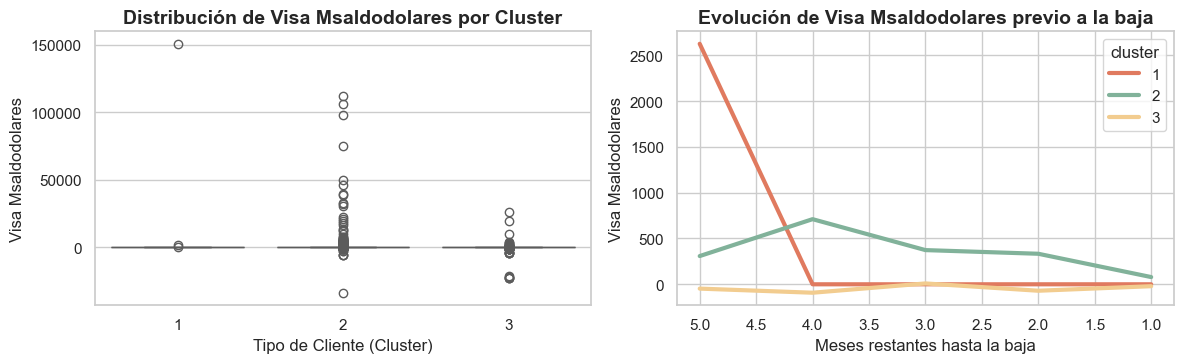

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


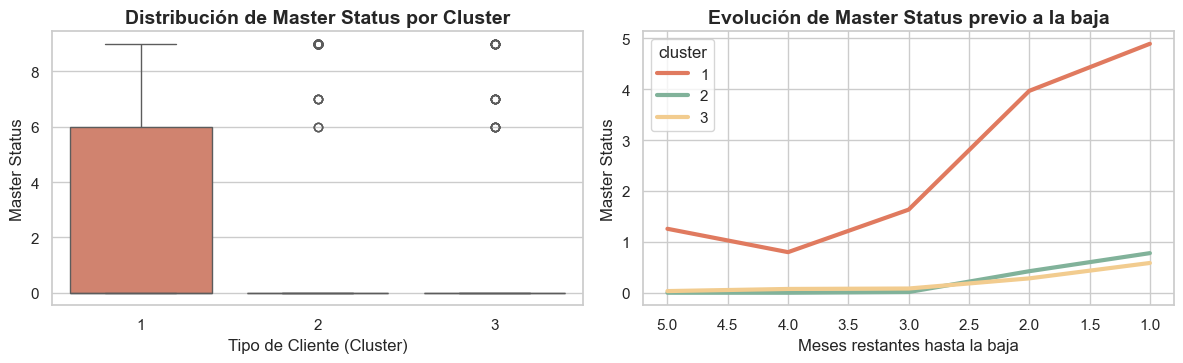

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


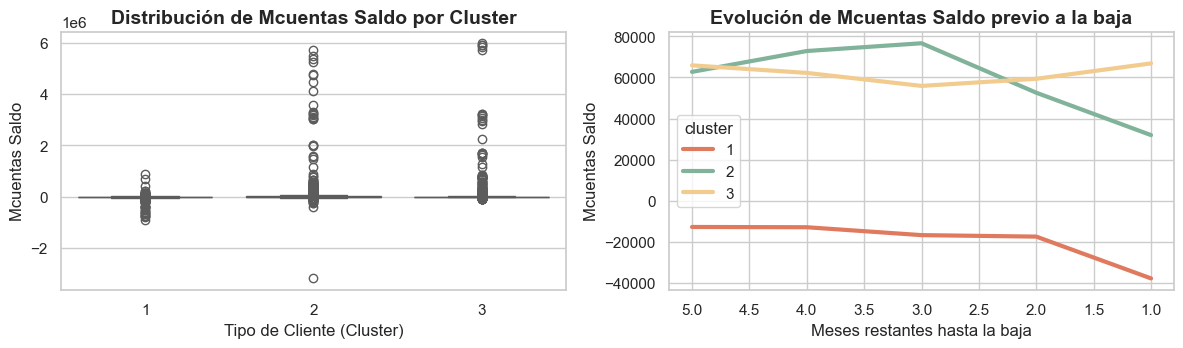

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


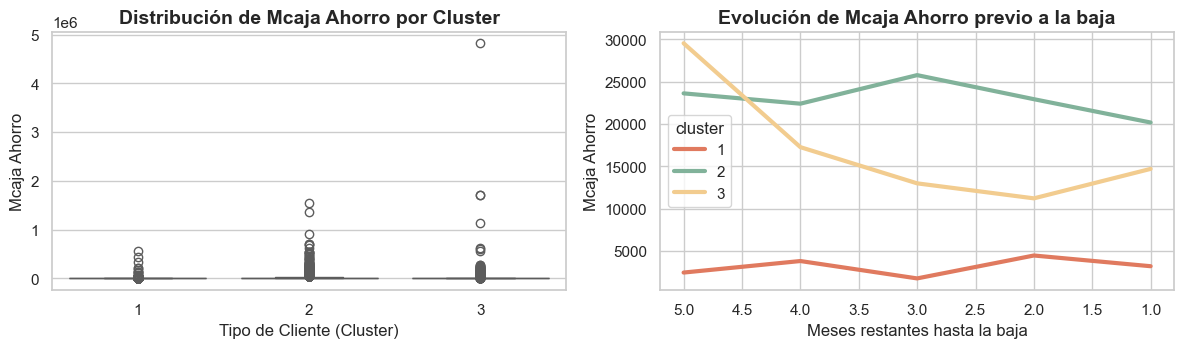

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


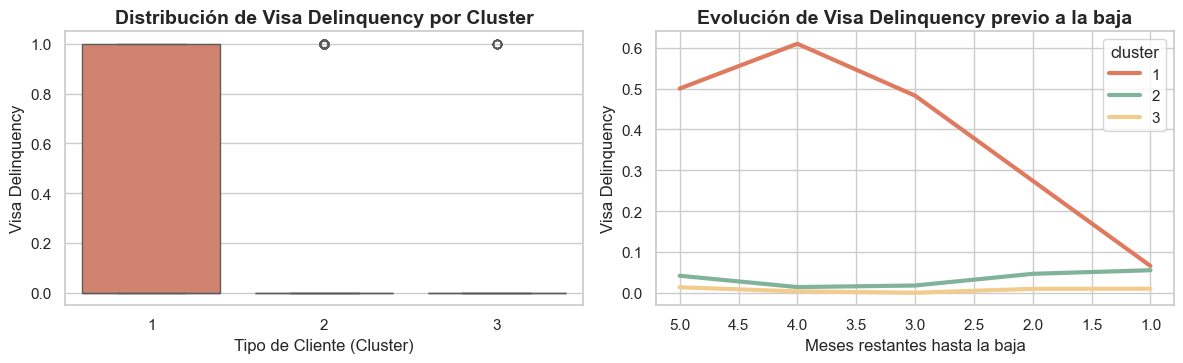

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


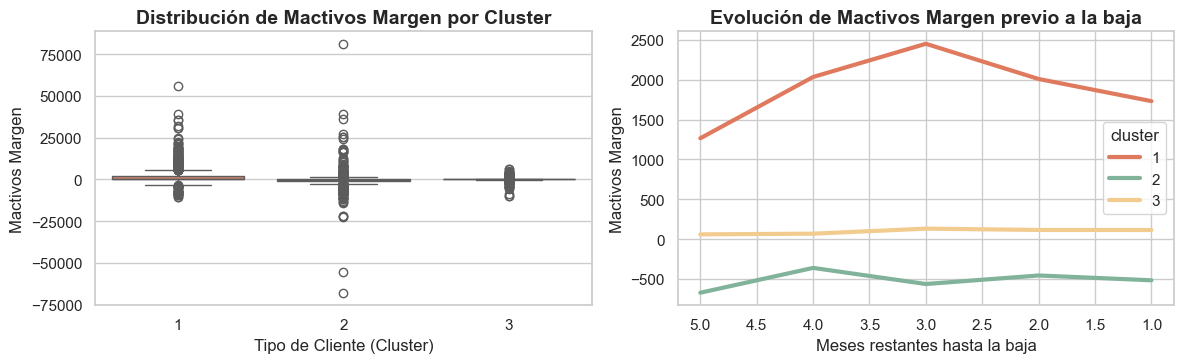

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


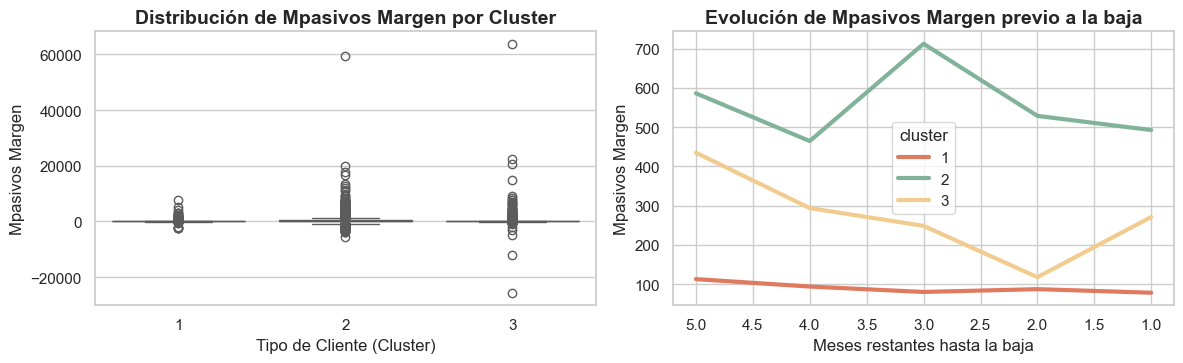

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


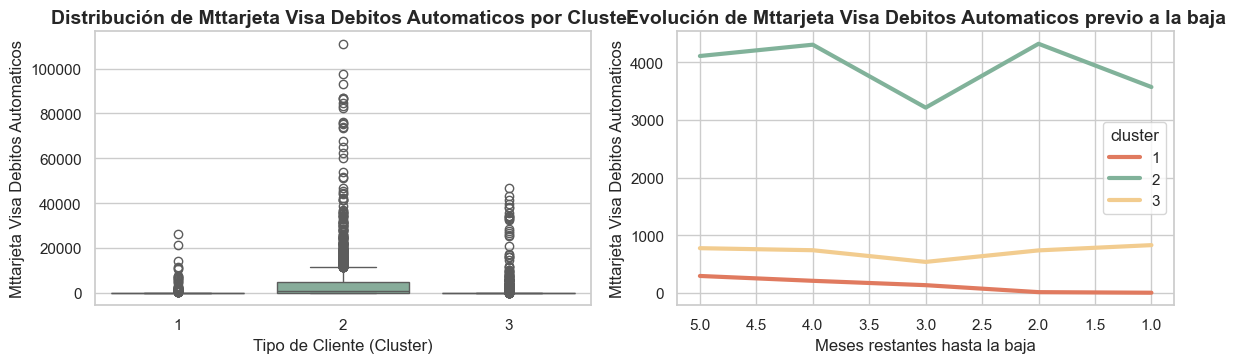

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


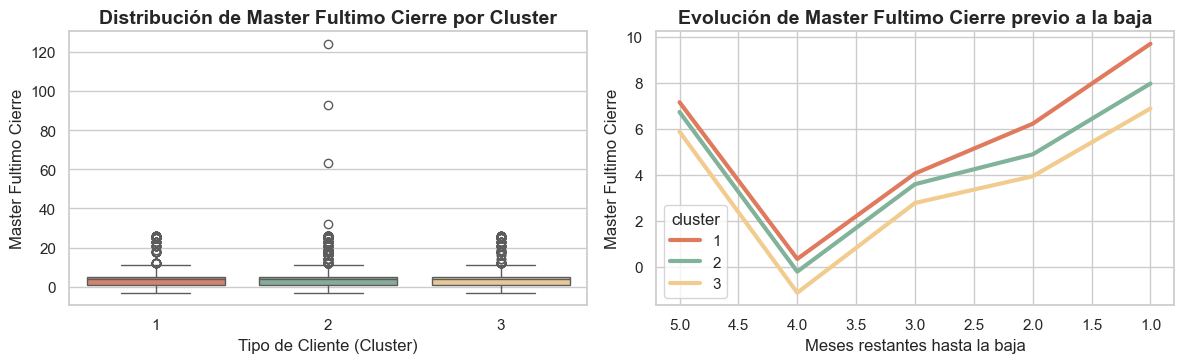

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


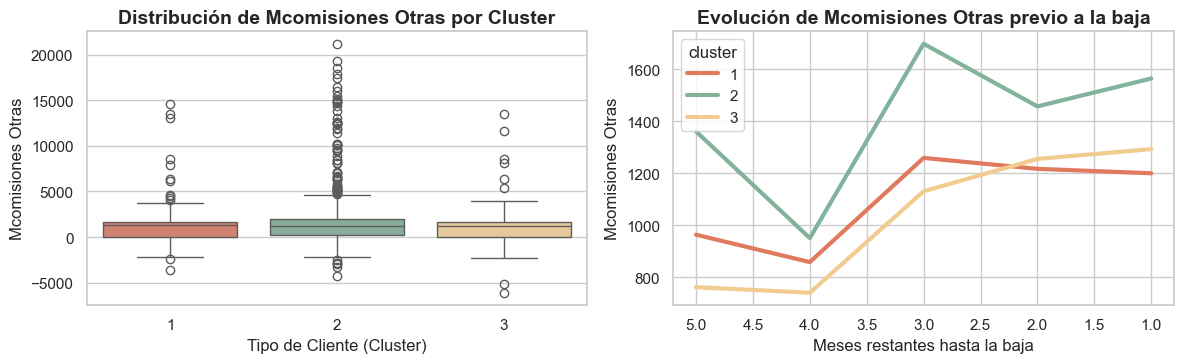

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


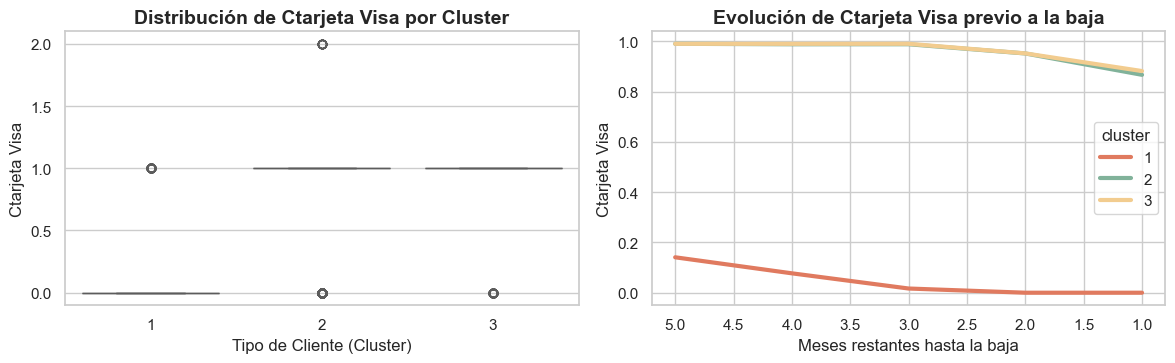

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


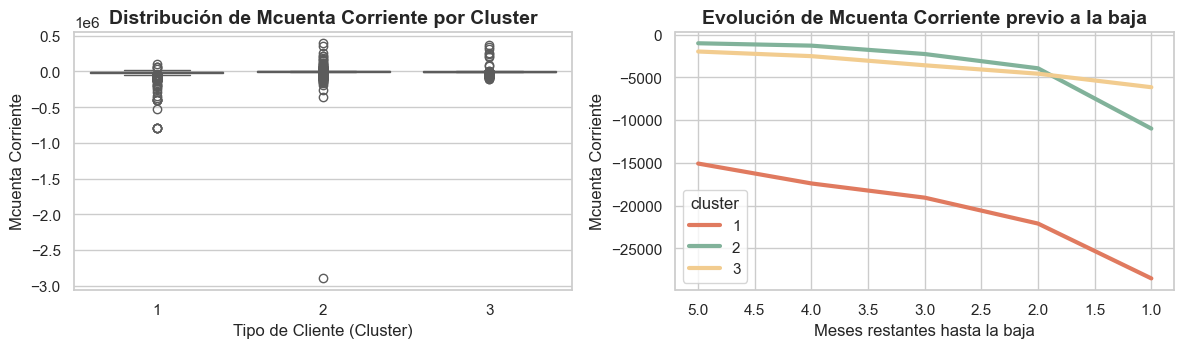

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


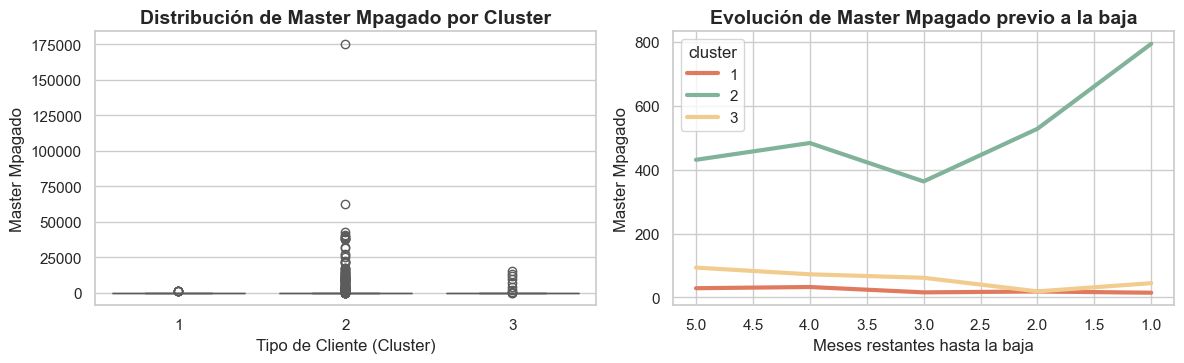

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/610439337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


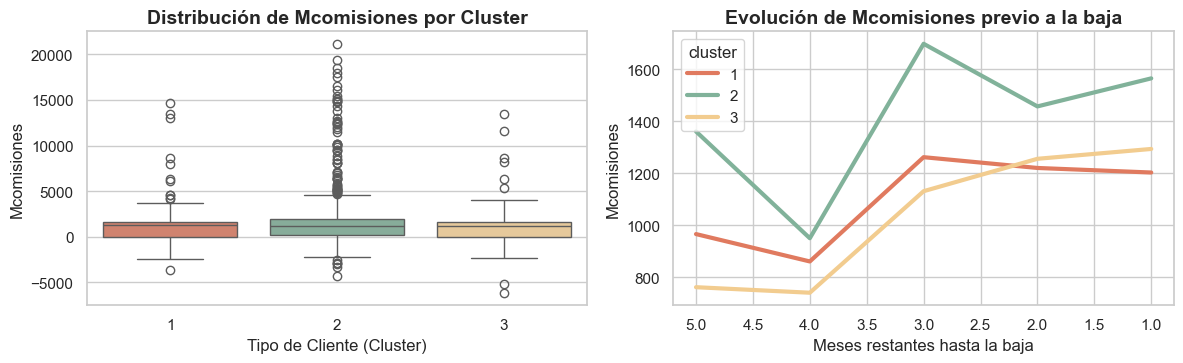

In [329]:
# Lista de las features que quieres graficar
features = df_importances['Feature'].to_list()

# Bucle para iterar sobre cada feature en la lista
for feature in features:
    # Configuración global del estilo de los gráficos
    sns.set_theme(style='whitegrid', palette='pastel')
    
    # Crear la figura y los ejes para los dos subgráficos
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
    
    # ---
    # Gráfico 1: Boxplot de la variable 'feature' por cluster
    sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,
                palette=['#e07a5f', '#81b29a', '#f2cc8f'])
    ax1.set_title(f'Distribución de {feature.replace("_", " ").title()} por Cluster', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Tipo de Cliente (Cluster)', fontsize=12)
    ax1.set_ylabel(feature.replace('_', ' ').title(), fontsize=12)
    
    # ---
    # Gráfico 2: Evolución de la variable 'feature' hasta la baja
    sns.lineplot(data=df_cluster, x='meses_hasta_baja', y=feature, hue='cluster',
                 estimator='mean', errorbar=None, ax=ax2,
                 palette=['#e07a5f', '#81b29a', '#f2cc8f'], linewidth=3)
    ax2.set_title(f'Evolución de {feature.replace("_", " ").title()} previo a la baja', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Meses restantes hasta la baja', fontsize=12)
    ax2.set_ylabel(feature.replace('_', ' ').title(), fontsize=12)
    ax2.invert_xaxis()
    
    # ---
    # Ajustes finales y visualización
    # plt.suptitle('Análisis de Tendencias en Clientes que se Dan de Baja', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    
    

In [260]:
X.columns.to_list()

['active_quarter',
 'cliente_vip',
 'internet',
 'cliente_edad',
 'cliente_antiguedad',
 'mrentabilidad',
 'mrentabilidad_annual',
 'mcomisiones',
 'mactivos_margen',
 'mpasivos_margen',
 'cproductos',
 'tcuentas',
 'ccuenta_corriente',
 'mcuenta_corriente_adicional',
 'mcuenta_corriente',
 'ccaja_ahorro',
 'mcaja_ahorro',
 'mcaja_ahorro_adicional',
 'mcaja_ahorro_dolares',
 'cdescubierto_preacordado',
 'mcuentas_saldo',
 'ctarjeta_debito',
 'ctarjeta_debito_transacciones',
 'mautoservicio',
 'ctarjeta_visa',
 'ctarjeta_visa_transacciones',
 'mtarjeta_visa_consumo',
 'ctarjeta_master',
 'ctarjeta_master_transacciones',
 'mtarjeta_master_consumo',
 'cprestamos_personales',
 'mprestamos_personales',
 'cprestamos_prendarios',
 'mprestamos_prendarios',
 'cprestamos_hipotecarios',
 'mprestamos_hipotecarios',
 'cplazo_fijo',
 'mplazo_fijo_dolares',
 'mplazo_fijo_pesos',
 'cinversion1',
 'minversion1_pesos',
 'minversion1_dolares',
 'cinversion2',
 'minversion2',
 'cseguro_vida',
 'cseguro_au

In [342]:
df_cluster['Visa_putilizacion'] = df_cluster['Visa_msaldototal'] / df_cluster['Visa_mlimitecompra']
df_cluster['Visa_ppagos'] = df_cluster['Visa_mpagado'] / df_cluster['Visa_msaldototal']
df_cluster['Visa_ppagomin'] = df_cluster['Visa_mpagado'] / df_cluster['Visa_mpagominimo']
df_cluster['cinversion'] = df_cluster['cinversion1'] + df_cluster['cinversion2']
df_cluster['minversion_pesos'] = df_cluster['minversion1_pesos'] + df_cluster['minversion2']

In [302]:
# df_cluster.groupby('cluster')['Visa_ppagomin'].value_counts()

In [301]:
# df_cluster[['Visa_mpagominimo','Visa_mpagado', 'Visa_ppagomin', 'cluster']]

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/2720630109.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


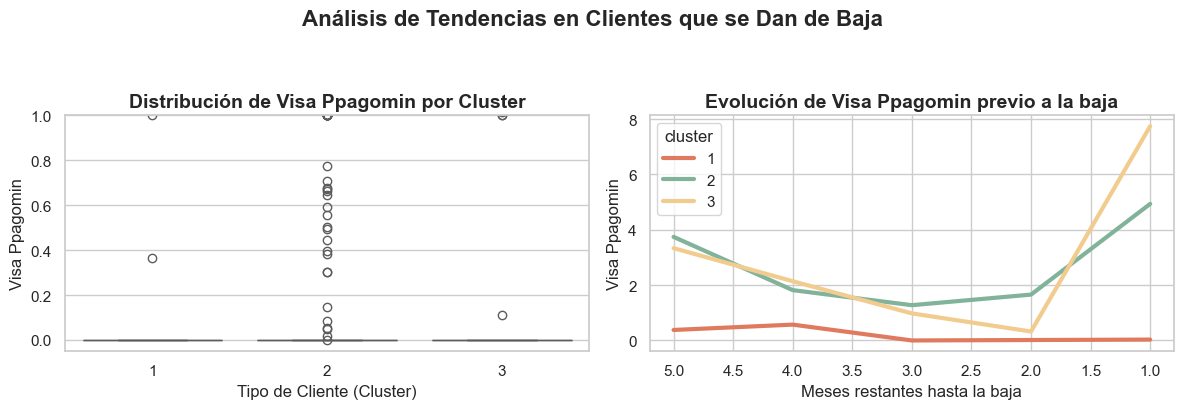

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/2720630109.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


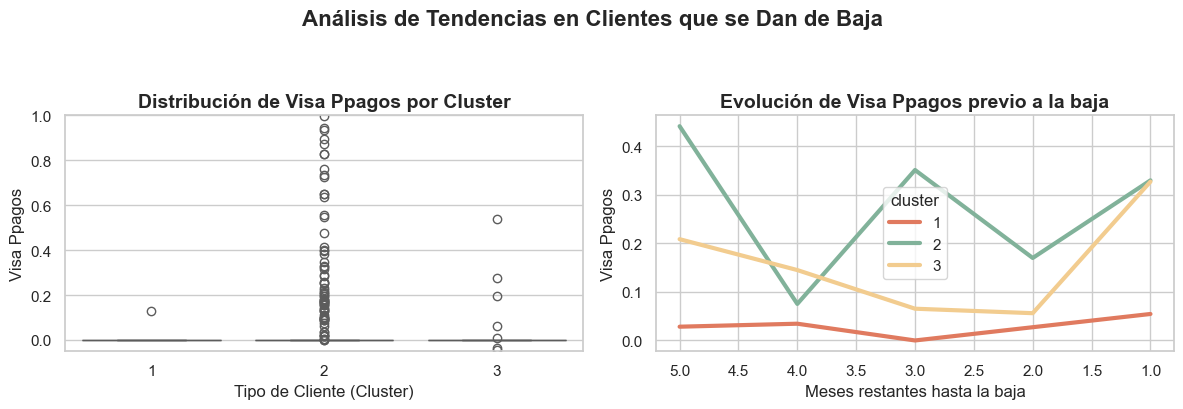

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/2720630109.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


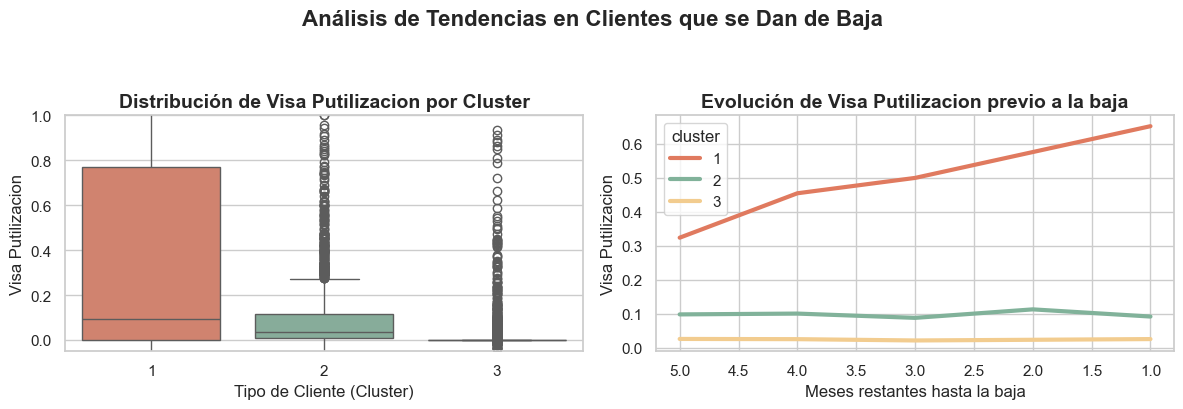

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/2720630109.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


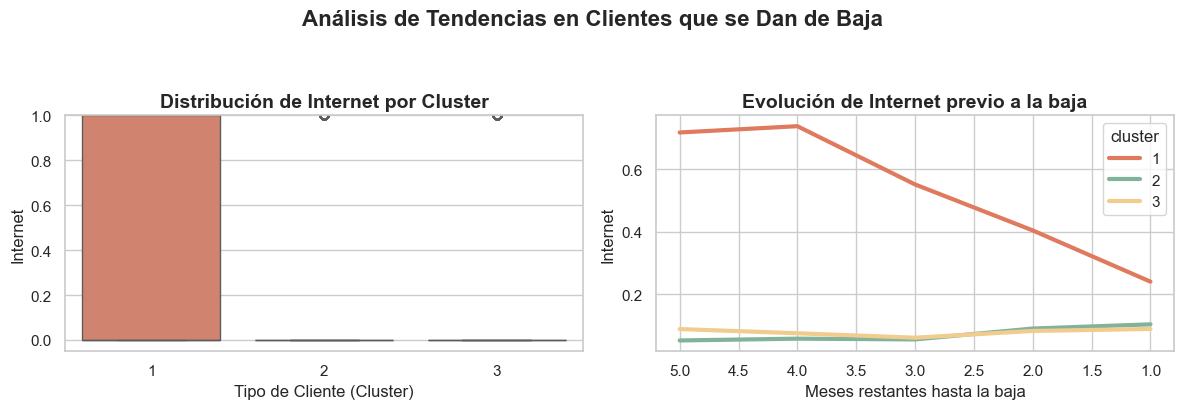

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/2720630109.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


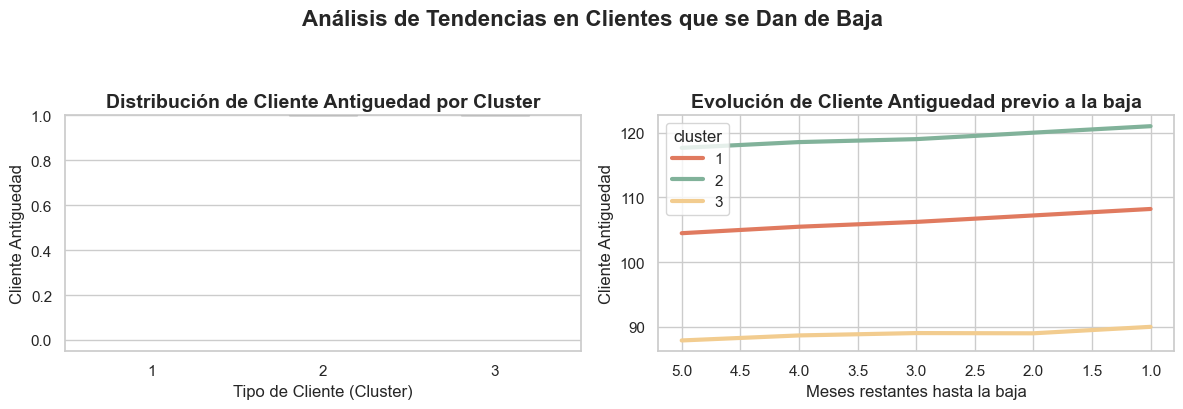

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/2720630109.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


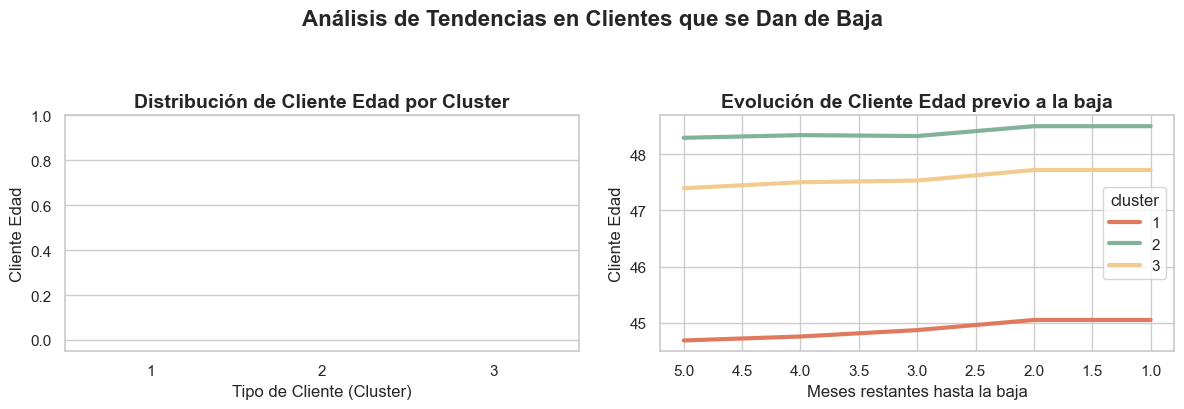

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/2720630109.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


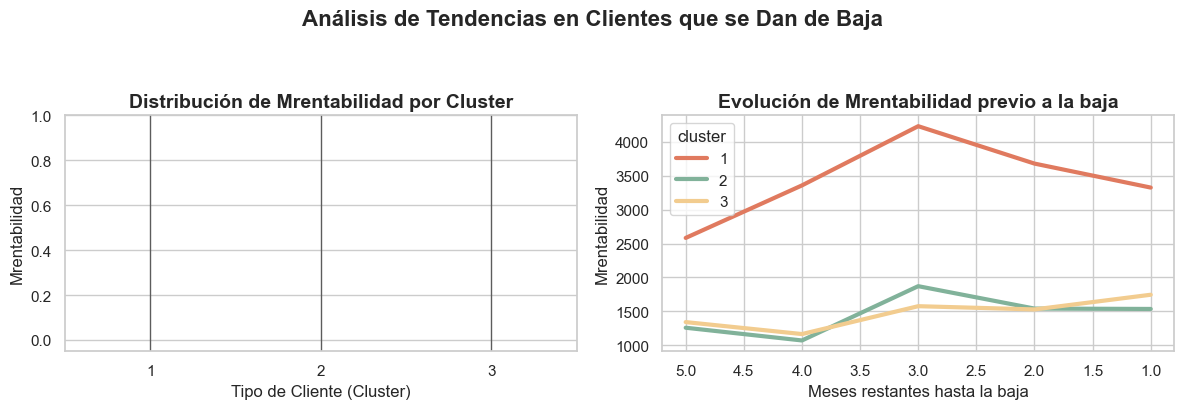

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/2720630109.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


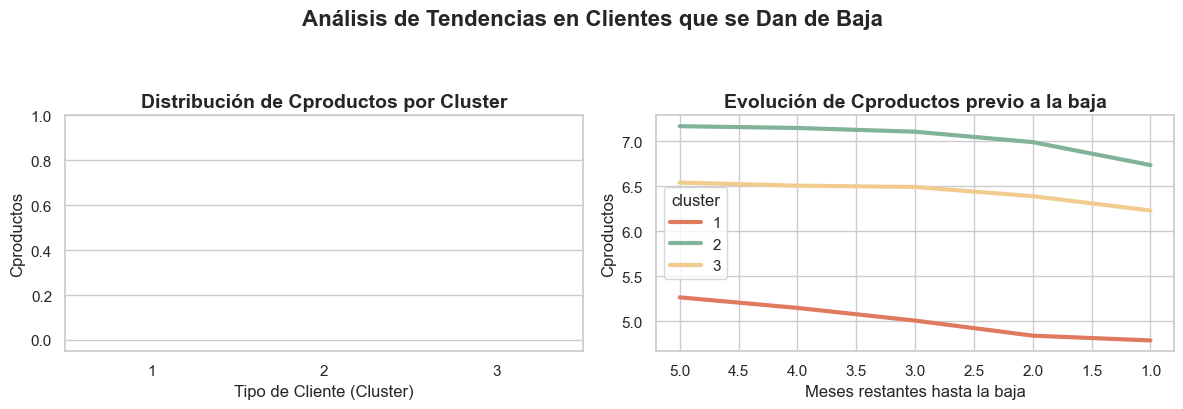

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/2720630109.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


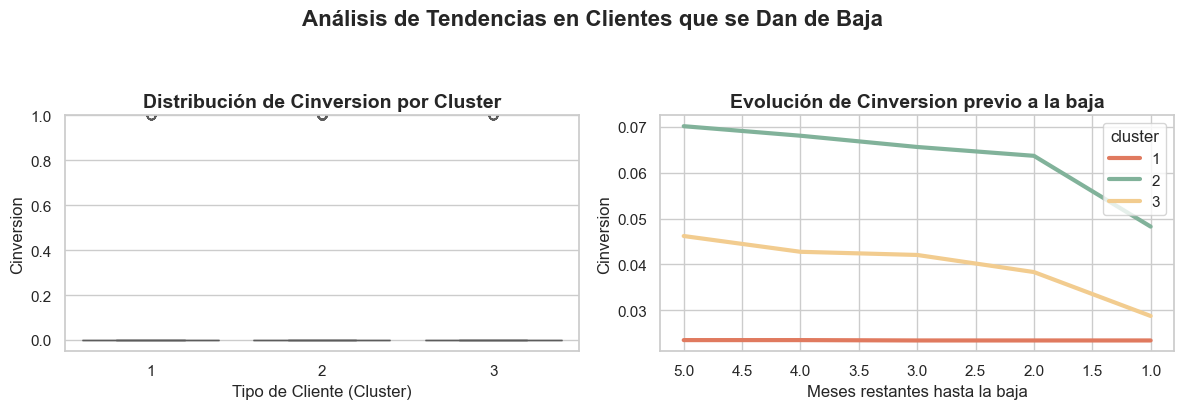

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/2720630109.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


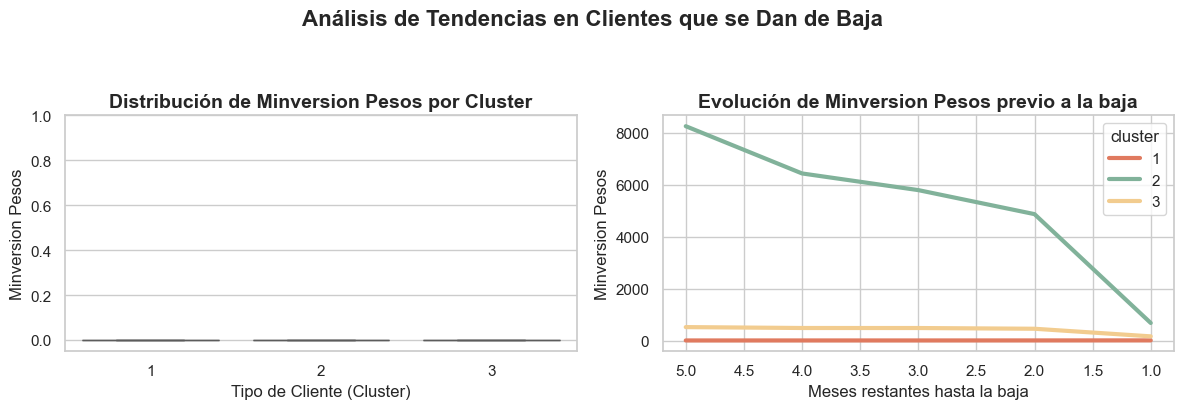

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/2720630109.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


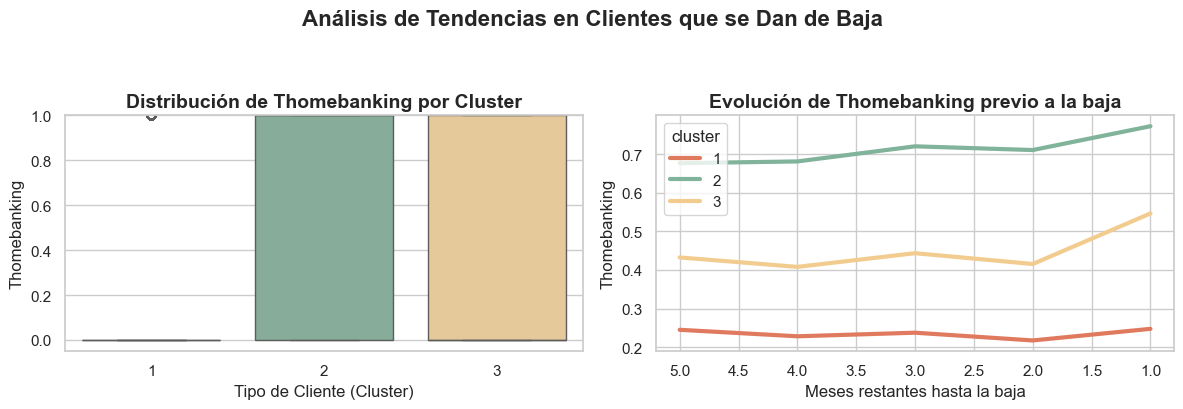

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/2720630109.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


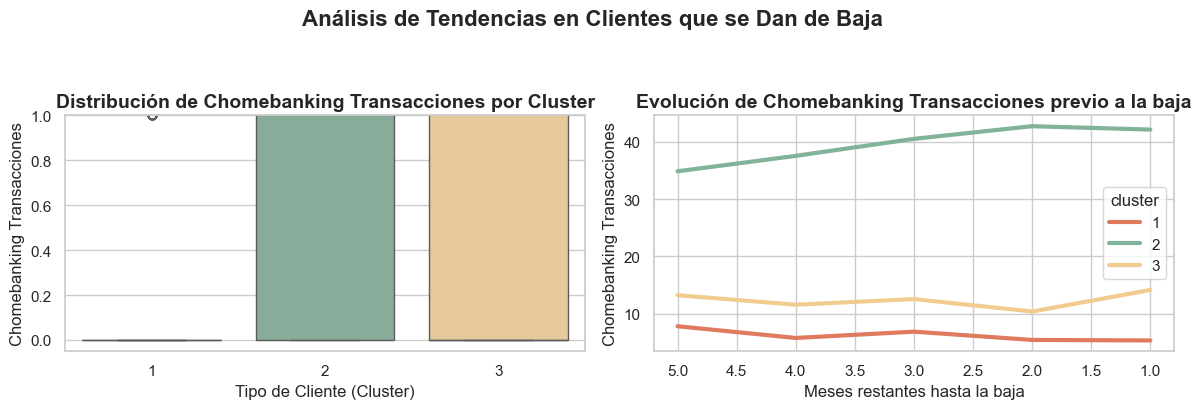

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/2720630109.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


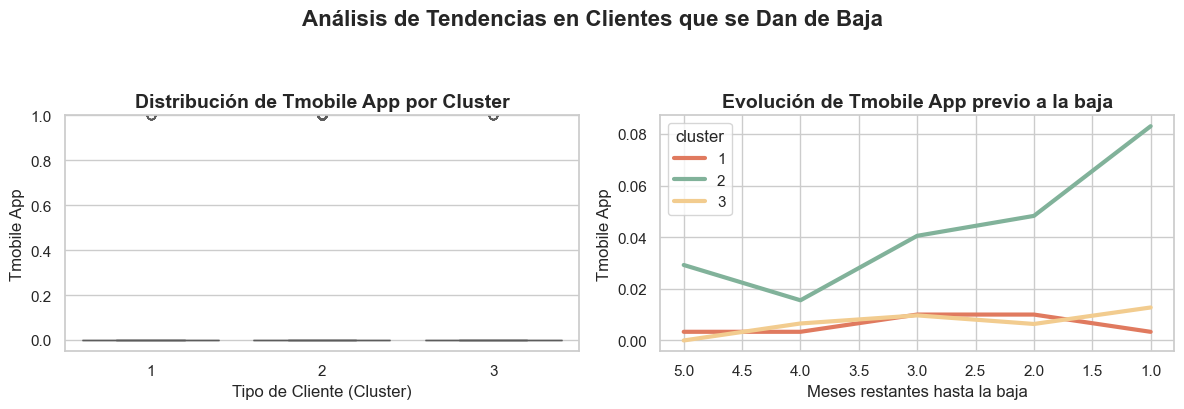

/var/folders/8q/7djkg4_55rsgfbzr3shf6lsc0000gn/T/ipykernel_55041/2720630109.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,


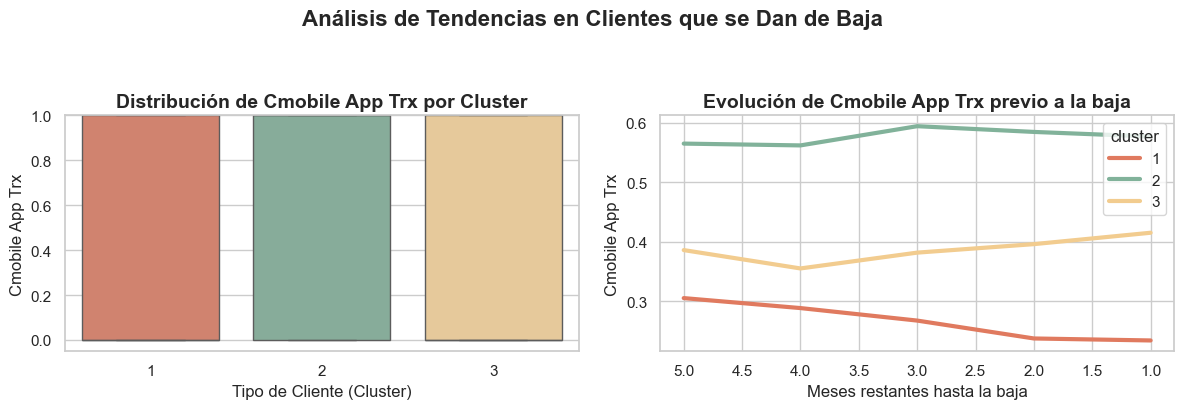

In [343]:
features_new = ['Visa_ppagomin','Visa_ppagos', 'Visa_putilizacion', 'internet', 'cliente_antiguedad', 'cliente_edad', 'mrentabilidad', 'cproductos', 'cinversion', 'minversion_pesos', 'thomebanking', 'chomebanking_transacciones', 'tmobile_app', 'cmobile_app_trx']

for feature in features_new:
    # Configuración global del estilo de los gráficos
    sns.set_theme(style='whitegrid', palette='pastel')
    
    # Crear la figura y los ejes para los dos subgráficos
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
    
    # ---
    # Gráfico 1: Boxplot de la variable 'feature' por cluster
    sns.boxplot(data=df_cluster, y=feature, x='cluster', ax=ax1,
                palette=['#e07a5f', '#81b29a', '#f2cc8f'])
    ax1.set_title(f'Distribución de {feature.replace("_", " ").title()} por Cluster', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Tipo de Cliente (Cluster)', fontsize=12)
    ax1.set_ylabel(feature.replace('_', ' ').title(), fontsize=12)
    ax1.set_ylim(-0.05, 1)
    
    # ---
    # Gráfico 2: Evolución de la variable 'feature' hasta la baja
    sns.lineplot(data=df_cluster, x='meses_hasta_baja', y=feature, hue='cluster',
                 estimator='mean', errorbar=None, ax=ax2,
                 palette=['#e07a5f', '#81b29a', '#f2cc8f'], linewidth=3)

    # Agrega la línea horizontal en y=1
    # ax2.axhline(y=1, color='grey', linestyle='--', label='Valor de Referencia')
    ax2.set_title(f'Evolución de {feature.replace("_", " ").title()} previo a la baja', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Meses restantes hasta la baja', fontsize=12)
    ax2.set_ylabel(feature.replace('_', ' ').title(), fontsize=12)
    ax2.invert_xaxis()
    
    # ---
    # Ajustes finales y visualización
    plt.suptitle('Análisis de Tendencias en Clientes que se Dan de Baja', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
